<a href="https://colab.research.google.com/github/7angel4/weighted-jk/blob/main/JKGCN_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

###Part 0. Set up dependencies
Run the following blocks of code to install the required packages.

In [5]:
!python -c "import torch; print(torch.__version__)"

2.6.0.dev20241112


In [6]:
%%capture
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-2.0.1+cu118.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Part 1. Oversmoothing

This part aims to investigate **oversmoothing**: we will consider different number of layers and visualise the corresponding node embeddings. Specifically, we will experiment using the following dataset and methods::

1.   Dataset: CORA
2.   Model: Graph Convolutional Network
3.   Dimensionality reduction method: T-SNE

### A. Model Implementation and Training

#### a. Import required packages

Please run the below code block to import the required python packages.

In [32]:
import torch
import os
import typing
import torch_geometric

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.datasets as datasets

from torch_geometric.nn import GCNConv

In [33]:
torch.manual_seed(77888) # set seed

b. Load CORA dataset

We will use `torch_geometric.datasets` to load the `Cora` dataset for node classification, which consists of 2,708 nodes, 10,556 edges, 1,433 features, and 7 classes.

In [34]:
%run datasets.ipynb

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


#### c. Setup graph convolutional networks for node classification
Here we define a GCN class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*.

- Note that the `forward` function should return a Tensor object: **logits**, and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


In [79]:
%run models.ipynb

#### c. Implement `train` and `evaluate` functions for training a node classification model.

- Apply **Early-stopping**: stop training if the validation accuracy decreases during *k* consecutive epochs.
- Use **Adam optimizer** for training.
- Use **evaluate** function for calculating the validation accuracy in every epoch to adapt early-stopping.

In [127]:
import torch.optim as optim
from torch_geometric.data import Data
from sklearn.metrics import f1_score

In [151]:
def evaluate(model, data, mask):
    """
    Evaluates model and returns its validation accuracy, 
    micro-F1 and macro-F1 scores on given mask.
    """
    model.eval()  # set to evaluation mode
    with torch.no_grad():  # disable gradient computation during evaluation
        # forward pass
        out = model(data.x, data.edge_index)
        # predict the class with max score
        pred = out.argmax(dim=1)
        true_labels = data.y[mask]
        
        # calculate accuracy
        correct = pred[mask] == true_labels
        accuracy = correct.sum() / mask.sum()

        # calculate F1 scores (`f1_score` expects the inputs to be on the CPU)
        micro_f1 = f1_score(true_labels.cpu(), pred[mask].cpu(), average='micro')
        macro_f1 = f1_score(true_labels.cpu(), pred[mask].cpu(), average='macro')

    return accuracy, micro_f1, macro_f1

In [80]:
import torch.optim as optim
from torch_geometric.data import Data

def evaluate(model, data, mask):
    """
    Evaluates model and returns its accuracy on given mask.
    """
    model.eval()  # to evaluation mode
    with torch.no_grad():  # disable gradient computation during evaluation
        # forward pass
        out = model(data.x, data.edge_index)
        # predict the class with max score
        pred = out.argmax(dim=1)
        correct = pred[mask] == data.y[mask]
        accuracy = correct.sum() / mask.sum()
    return accuracy

In [132]:
def init_training(params):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = load_data(device, params['dataset'])
    params["n_classes"] = dataset.num_classes  # number of target classes
    params["input_dim"] = dataset.num_features  # size of input features
    
    model = set_model(params, device)
    model.param_init()
    
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    loss_fn = nn.CrossEntropyLoss()
    
    return model, data, optimizer, loss_fn

In [138]:
def train(params: typing.Dict,
          report_per_period=10) -> torch.nn.Module:
    """
    Trains a node classification model and
    returns the trained model object.
    """
    model, data, optimizer, loss_fn = init_training(params)
    n_epochs = params['epochs']

    # variables for early stopping
    best_val_acc = 0  # best validation accuracy
    prev_loss = float('inf')
    epochs_dec_acc = 0  # number of consecutive epochs with decreasing validation accuracy
    # k: stop if epochs_dec_acc >= patience
    patience = params['max_patience']

    # standard training with backpropagation
    for epoch in range(n_epochs):
        model.train()
        optimizer.zero_grad()
        out = model(data.x, data.edge_index) # forward pass
        loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
        loss.backward() # backward pass
        optimizer.step()

        # evaluate on validation set
        val_acc = evaluate(model, data, data.val_mask)[0]

        # early stopping
        if val_acc >= best_val_acc:
            best_val_acc = val_acc
            epochs_dec_acc = 0
        else:
            epochs_dec_acc += 1

        # patience exceeded -> stop training
        if epochs_dec_acc >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            print(f"Best validation accuracy: {best_val_acc}")
            break

        # print training progress
        if epoch % report_per_period == 0:
            print(f"Epoch {epoch + 1}/{n_epochs}...")
            print(f"Loss: {loss};")
            print(f"Validation Accuracy: {val_acc}\n")

    return model

#### d. Set training hyper-parameters

In [136]:
default_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "SkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "Cora"
}

In [137]:
train(default_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.8767873212153856e+17;
Validation Accuracy: 0.16200000047683716

Epoch 11/1000...
Loss: 15495510097920.0;
Validation Accuracy: 0.3160000145435333

Epoch 21/1000...
Loss: 12788037582848.0;
Validation Accuracy: 0.3160000145435333

Epoch 31/1000...
Loss: 3862756589568.0;
Validation Accuracy: 0.3160000145435333

Epoch 41/1000...
Loss: 1898723934208.0;
Validation Accuracy: 0.3160000145435333

Epoch 51/1000...
Loss: 1228141887488.0;
Validation Accuracy: 0.3160000145435333

Epoch 61/1000...
Loss: 1086852169728.0;
Validation Accuracy: 0.3160000145435333

Epoch 71/1000...
Loss: 981714927616.0;
Validation Accuracy: 0.3160000145435333

Epoch 81/1000...
Loss: 1151657967616.0;
Validation Accuracy: 0.3160000145435333

Epoch 91/1000...
Loss: 492371181568.0;
Validation Accuracy: 0.3160000145435333

Epoch 101/1000...
Loss: 419920052224.0;
Validation Accuracy: 0.3160000145435333

Epoch 111/1000...
Loss: 392854601728.0;
Validation Accuracy: 0.3160000145435333

Epoch 121/1000...
Los

SkipGCN(
  (layers): ModuleList(
    (0): GCNConv(1433, 64)
    (1-99): 99 x GCNConv(64, 64)
  )
  (mlp): Linear(in_features=64, out_features=7, bias=True)
)

#### e. Train 4 GCN models with varying number of layers.

In [146]:
def train_varying_layers_model(model_name,
                               params=default_training_params,
                               report_per_period=100):
    n_layers_model = dict()
    num_layers = range(2,21,3)
    params['model_name'] = model_name
    for n in num_layers:
        params['n_layers'] = n
        n_layers_model[n] = train(params, report_per_period=100)

    return n_layers_model

In [140]:
train_model('GCN')

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.946994662284851;
Validation Accuracy: 0.4359999895095825



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.945305347442627;
Validation Accuracy: 0.18400000035762787



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9450286626815796;
Validation Accuracy: 0.07999999821186066



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9456475973129272;
Validation Accuracy: 0.07000000029802322



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.945797085762024;
Validation Accuracy: 0.20000000298023224

Epoch 701/1000...
Loss: 0.22671939432621002;
Validation Accuracy: 0.6779999732971191



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9459044933319092;
Validation Accuracy: 0.15800000727176666

Epoch 301/1000...
Loss: 0.381893515586853;
Validation Accuracy: 0.6359999775886536



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9459378719329834;
Validation Accuracy: 0.057999998331069946

Epoch 101/1000...
Loss: 1.652262806892395;
Validation Accuracy: 0.34200000762939453



{2: GCN(
   (layers): ModuleList(
     (0): GCNConv(1433, 64)
     (1): GCNConv(64, 64)
   )
   (mlp): Linear(in_features=64, out_features=7, bias=True)
 ),
 5: GCN(
   (layers): ModuleList(
     (0): GCNConv(1433, 64)
     (1-4): 4 x GCNConv(64, 64)
   )
   (mlp): Linear(in_features=64, out_features=7, bias=True)
 ),
 8: GCN(
   (layers): ModuleList(
     (0): GCNConv(1433, 64)
     (1-7): 7 x GCNConv(64, 64)
   )
   (mlp): Linear(in_features=64, out_features=7, bias=True)
 ),
 11: GCN(
   (layers): ModuleList(
     (0): GCNConv(1433, 64)
     (1-10): 10 x GCNConv(64, 64)
   )
   (mlp): Linear(in_features=64, out_features=7, bias=True)
 ),
 14: GCN(
   (layers): ModuleList(
     (0): GCNConv(1433, 64)
     (1-13): 13 x GCNConv(64, 64)
   )
   (mlp): Linear(in_features=64, out_features=7, bias=True)
 ),
 17: GCN(
   (layers): ModuleList(
     (0): GCNConv(1433, 64)
     (1-16): 16 x GCNConv(64, 64)
   )
   (mlp): Linear(in_features=64, out_features=7, bias=True)
 ),
 20: GCN(
   (layer

## Testing

In [147]:
def test(model, params):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = load_data(device, params['dataset'])
    return evaluate(model, data, data.test_mask)

In [159]:
def train_and_test(params, print_results=True):
    n_layers_model = train_varying_layers_model(params['model_name'], params)
    n_layers_results = dict()
    for n, model in n_layers_model.items():
        n_layers_results[n] = test(model, params)

    if print_results:
        print(f"Test results for {params['model_name']}:")
        for n, (accuracy, micro_f1, macro_f1) in n_layers_results.items():
            print(f"{n}-layer model:")
            print(f"  accuracy = {accuracy}")
            print(f"  micro_f1 = {micro_f1}")
            print(f"  macro_f1 = {macro_f1}")
        print()
    return n_layers_model, n_layers_results

In [157]:
gcn_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "GCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "Cora"
}
gcn_results = train_and_test(gcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.950589656829834;
Validation Accuracy: 0.5519999861717224



KeyboardInterrupt: 

In [164]:
gcn_results

NameError: name 'gcn_results' is not defined

In [162]:
sgcn_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "SkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "Cora"
}
sgcn_results = train_and_test(sgcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9425288438796997;
Validation Accuracy: 0.3700000047683716



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 1.9539363384246826;
Validation Accuracy: 0.42399999499320984



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 2.2345142364501953;
Validation Accuracy: 0.057999998331069946



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 6.4565277099609375;
Validation Accuracy: 0.12200000137090683



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 21.647369384765625;
Validation Accuracy: 0.05999999865889549



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 46.25682067871094;
Validation Accuracy: 0.057999998331069946



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Epoch 1/1000...
Loss: 223.38475036621094;
Validation Accuracy: 0.052000001072883606

Test results for SkipGCN:
2-layer model:
  accuracy = 0.7289999723434448
  micro_f1 = 0.729
  macro_f1 = 0.7246129017569796
5-layer model:
  accuracy = 0.7020000219345093
  micro_f1 = 0.702
  macro_f1 = 0.7055790932754774
8-layer model:
  accuracy = 0.6850000023841858
  micro_f1 = 0.685
  macro_f1 = 0.6874687375929438
11-layer model:
  accuracy = 0.6190000176429749
  micro_f1 = 0.619
  macro_f1 = 0.6295005358170533
14-layer model:
  accuracy = 0.4320000112056732
  micro_f1 = 0.432
  macro_f1 = 0.4293395874041911
17-layer model:
  accuracy = 0.40400001406669617
  micro_f1 = 0.404
  macro_f1 = 0.3840115360423763
20-layer model:
  accuracy = 0.2290000021457672
  micro_f1 = 0.229
  macro_f1 = 0.23047731523456344



/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

In [163]:
sgcn_results

({2: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1): GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  5: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-4): 4 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  8: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-7): 7 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  11: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-10): 10 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  14: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-13): 13 x GCNConv(64, 64)
    )
    (mlp): Linear(in_features=64, out_features=7, bias=True)
  ),
  17: SkipGCN(
    (layers): ModuleList(
      (0): GCNConv(1433, 64)
      (1-16): 16 x GCNConv(64, 64)
    )
    (mlp): Linear(i

In [160]:
wsgcn_training_params = {
    "lr": 0.01,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 1000,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": 100, # number of layers
    "model_name": "WeightedSkipGCN",
    "init_res_weight": 0.3,
    "dropout_ratio": 0.3,
    "dataset": "Cora"
}
wsgcn_results = train_and_test(wsgcn_training_params)

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
Epoch 1/1000...
Loss: 1.9378235340118408;
Validation Accuracy: 0.6200000047683716

current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residua

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2973, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3052, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3052, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3135, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3135, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3224, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3224, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3315, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3315, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3402, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3402, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3483, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2937, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3007, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3007, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3088, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3088, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3173, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3173, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3262, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3262, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3354, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3354, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3448, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 2.0372273921966553;
Validation Accuracy: 0.12399999797344208

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2808, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2808, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2718, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2718, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2646, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2646, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2608, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2608, requires_grad=True)
current residu

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2800, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2800, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2717, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2717, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2652, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2652, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2591, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2591, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2527, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2527, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2466, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 2.6844098567962646;
Validation Accuracy: 0.07400000095367432

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2814, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2814, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2744, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2744, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2686, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2686, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2638, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2638, requires_grad=True)
current residu

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 2.995831251144409;
Validation Accuracy: 0.16200000047683716

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2821, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2821, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2752, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2752, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2688, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2688, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2633, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2633, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2587, requires_grad=True)
current residual weight: Parameter conta

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data

In [156]:
wsgcn_results

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
Epoch 1/1000...
Loss: 1.9391871690750122;
Validation Accuracy: 0.5680000185966492

current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3000, requires_grad=True)
current residua

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
Epoch 1/1000...
Loss: 1.967189908027649;
Validation Accuracy: 0.3319999873638153

current residual weight: Parameter containing:
tensor(0.2900, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2962, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.2962, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3037, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3037, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3117, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3117, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3203, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3203, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3293, requires_grad=True)
current residual

/opt/anaconda3/lib/python3.12/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


current residual weight: Parameter containing:
tensor(0.2943, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3012, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3012, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3091, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3091, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3175, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3175, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3264, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3264, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3355, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3355, requires_grad=True)
current residual weight: Parameter containing:
tensor(0.3434, requires_grad=True)
current residual

KeyboardInterrupt: 

### B. Visualisation

We will generate node embeddings, reduce their dimensions, and finally visualsie these embeddings: we expect to empirically observe that the embeddings become more and more similar with more layers.

Please use the **validation dataset** for the visualisation.

#### a. Import required packages

In [ ]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
warnings.simplefilter(action='ignore', category=FutureWarning)

#### b. Task 3) Implement a function for demensionality reduction

- The `dimension_reduction` function will take a model object and data, perform T-SNE, and return a *DataFrame* that contains reduced variables and labels for each data point.
- Please reduce the dimension to 2d.
- Use validation data for the visualisation

** You may refer this address below using T-SNE:
[Link to sklearn T-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)

In [ ]:
def dimension_reduction(model: nn.Module) -> pd.DataFrame:
    """
    Args:
    - model: model object for generating features
    Returns:
    - pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2',
                    and 'labels' as a column
     """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    data = load_data(device)

    model.eval()
    x = data.x.to(device)  # node features
    edge_index = data.edge_index.to(device)  # graph structure

    # get node embeddings
    with torch.no_grad():  # disable gradient calculation
        node_embeddings = model.generate_node_embeddings(x, edge_index) # (X, A)

    # dim-reduction of node embeddings with T-SNE (to 2D)
    tsne = TSNE(n_components=2, random_state=123)
    # need to copy Tensor to host memory first with .cpu().numpy()
    reduced_embeddings = tsne.fit_transform(node_embeddings.cpu().numpy())

    # format result df
    reduced_df = pd.DataFrame(reduced_embeddings,
                              columns=['dimension 1', 'dimension 2'])
    reduced_df['labels'] = data.y.cpu().numpy()  # target labels

    return reduced_df


#### c. Generate reduced embeddings for each model and save them in a dictionary object

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

#### d. Task 4) Implement a function for the visualisation and draw scatter plots

- Using `matplotlib` package is recommended, but you may use any other tool.
- Please refer to this page if you are not familar with the visualisation tool: [Link](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html)

In [ ]:
def visualise_one(model_name, df) -> None:
    """Visualize node embeddings as a scatter plot for one model."""

    # plot
    fig, ax = plt.subplots(figsize=(10, 8))
    scatter = ax.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'],
                         cmap='tab10', s=10)
    plt.colorbar(scatter, ax=ax, label='class')  # color bar for classes

    ax.set_title("Visualization of node embeddings (dim-reduced by T-SNE)",
                 fontsize=16)
    ax.set_xlabel("dimension 1", fontsize=14)
    ax.set_ylabel("dimension 2", fontsize=14)

    # show the plot
    plt.show()
    fig.savefig(f'P4_visualization_{model_name}.jpg', bbox_inches='tight')

In [ ]:
def visualise(feature_dict: typing.Dict) -> None:
    """Visualize node embeddings as a scatter plot
       for all models in `feature_dict`."""
    for model in feature_dict.items():
        visualise_one(*model)

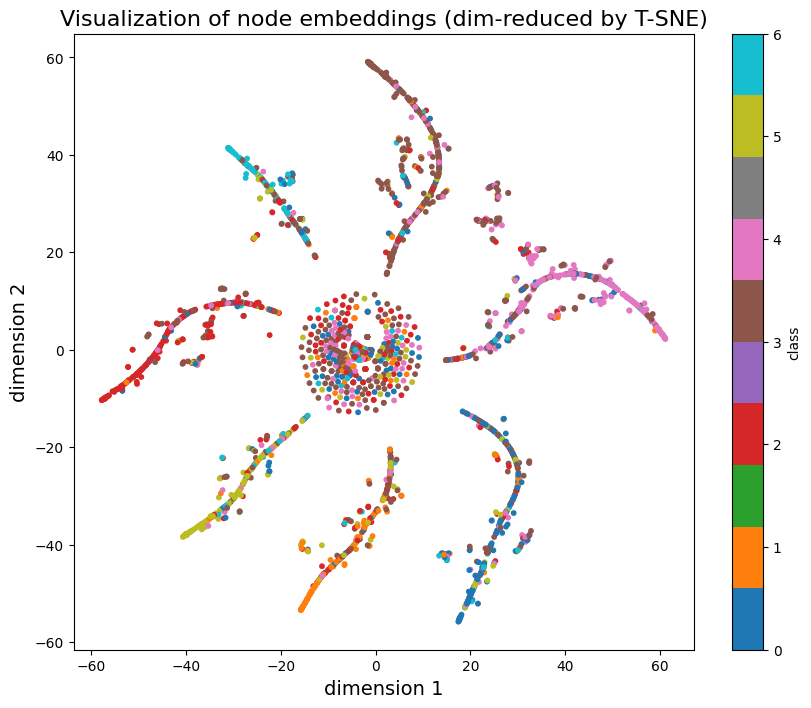

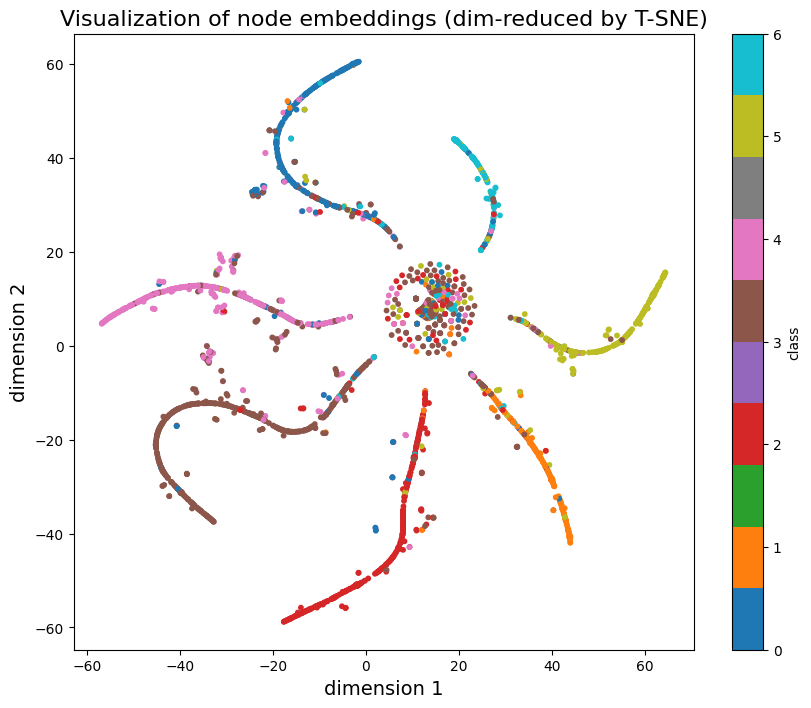

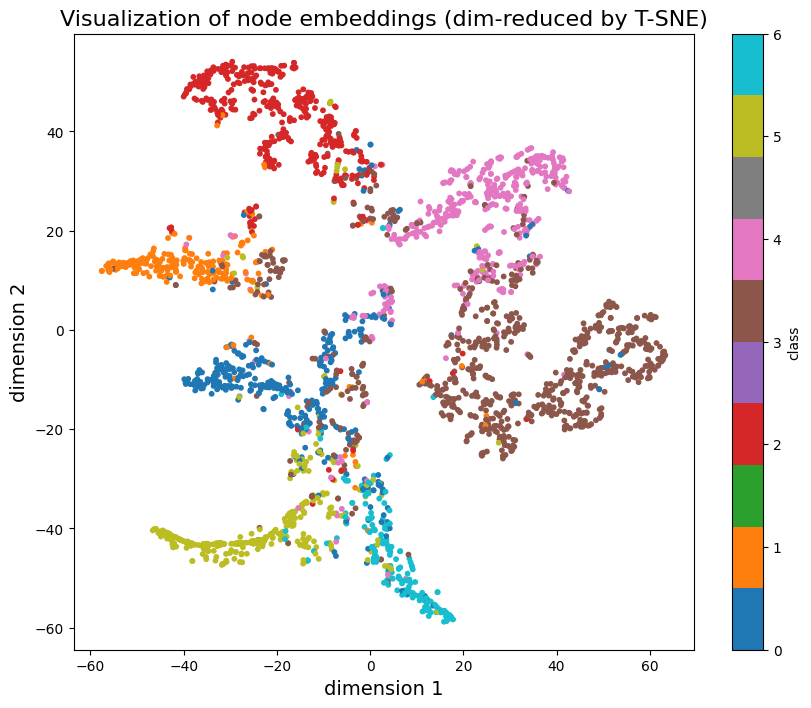

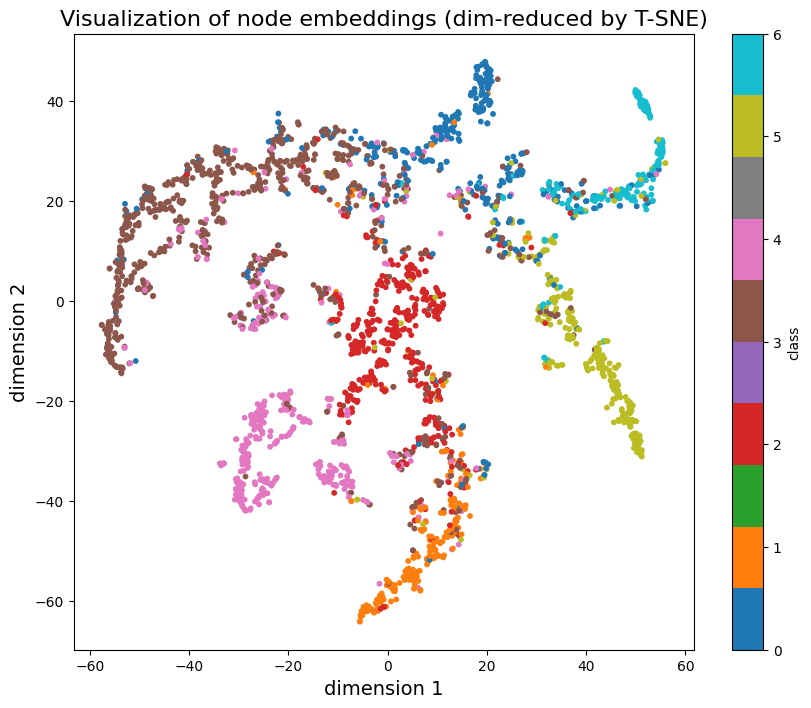

In [ ]:
visualise(feature_dict)

## Part 2. Skip-Connections

In this section, we will investigate whether skip-connections can alleviate the effect of over-smoothing.

#### a. Task 5) Setup graph convolutional network with skip-connections
Define a SkipGCN class for node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using **residual connection** is recommended, but you may also use other techniques, like **concatenation**.

- Note that the `forward` function should return a Tensor object: **logits**, and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `F.relu` and `F.dropout` at the end of each layer.


#### b. Repeat experiments and Visualise the embeddings

In [ ]:
feature_dict = {
    "0_layer": dimension_reduction(model_0_layer),
    "1_layer": dimension_reduction(model_1_layer),
    "3_layer": dimension_reduction(model_3_layer),
    "10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

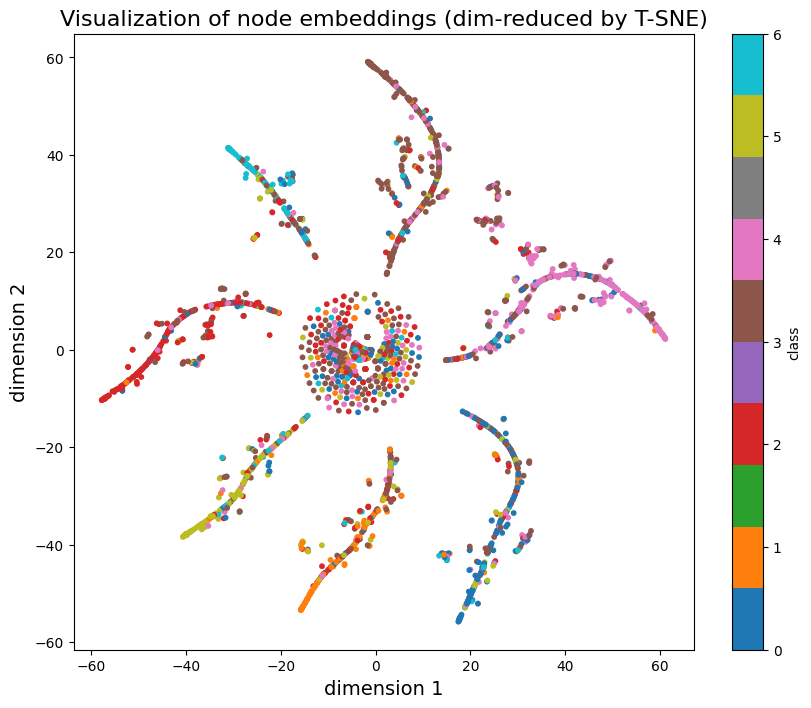

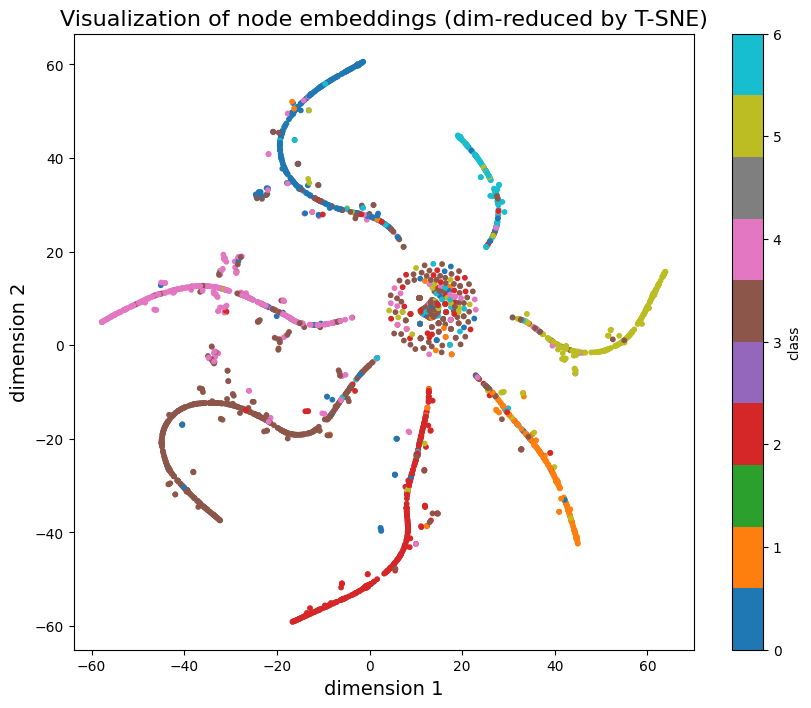

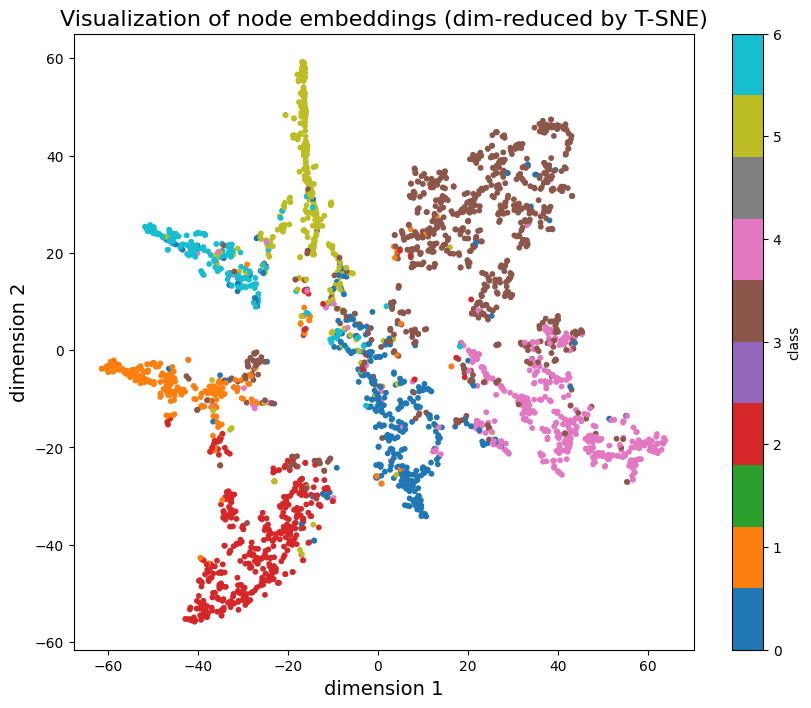

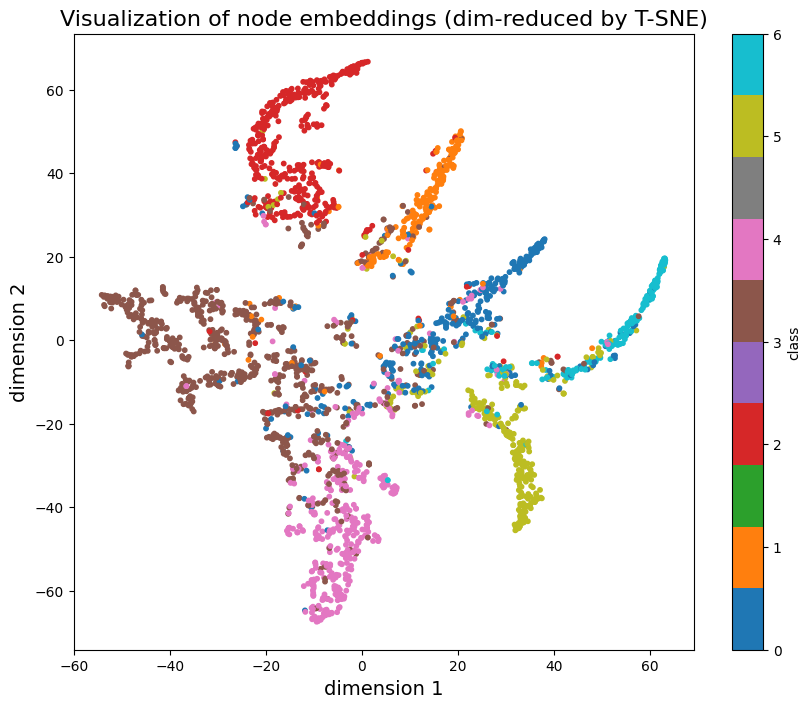

In [ ]:
visualise(feature_dict)

## Optional) Jumping Knowledge Connection

#### a. Task6) Design Graph Convolutional Network with Jumping Knowledge Connection
Define a `JumpKnowGCN` class for a node classification that takes five inputs: *input_dim*, *hid_dim*, *n_class*, *n_layers*, and *dropout_ratio*. Using `max_pooling` is recommended but you may also use other differentiable functions.

- Note that the `forward` function should return a Tensor object: **logits** and the `generate_node_embeddings` fuction should return a Tensor object: **node_embeddings**, which is the representation of the last layer.
- For the case when the *n_layers=0*, implement a single feed-forward network.
- Use `relu` and `dropout` at the end of each layer.


#### b. Repeat experiments and Visualise the embeddings

In [ ]:
# added prefix 'jk_' to distinguish model names in output visualization files
feature_dict = {
    "jk_0_layer": dimension_reduction(model_0_layer),
    "jk_1_layer": dimension_reduction(model_1_layer),
    "jk_3_layer": dimension_reduction(model_3_layer),
    "jk_10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

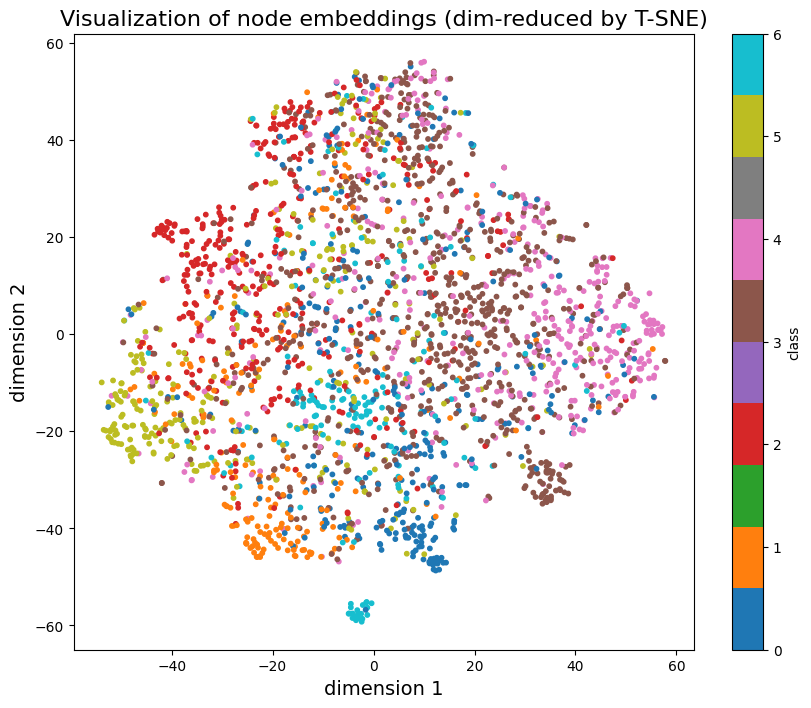

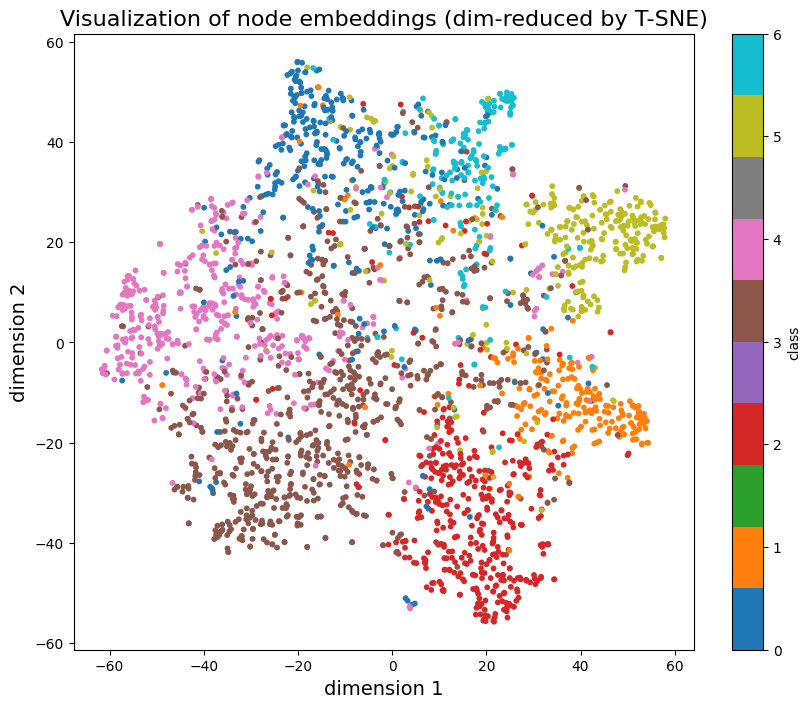

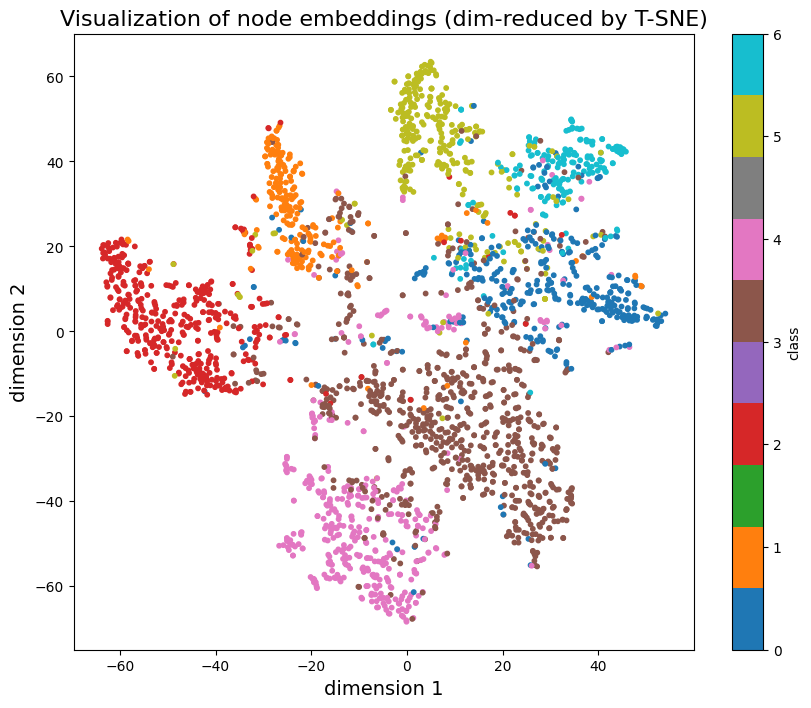

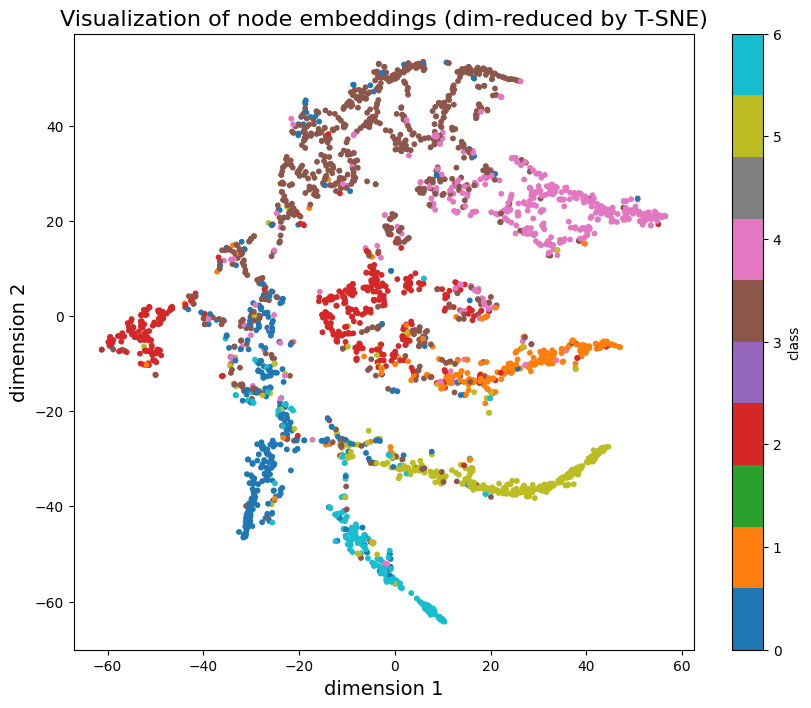

In [ ]:
visualise(feature_dict)

# MY NEW MODEL

In [ ]:
# added prefix 'ws_' to distinguish model names in output visualization files
feature_dict = {
    "ws_0_layer": dimension_reduction(model_0_layer),
    "ws_1_layer": dimension_reduction(model_1_layer),
    "ws_3_layer": dimension_reduction(model_3_layer),
    "ws_10_layer": dimension_reduction(model_10_layer),
}

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_d

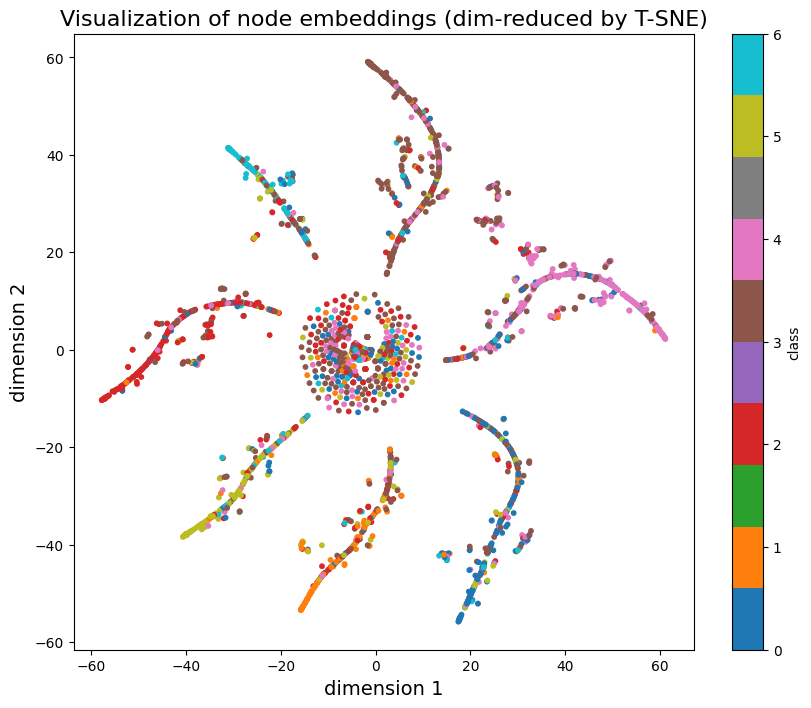

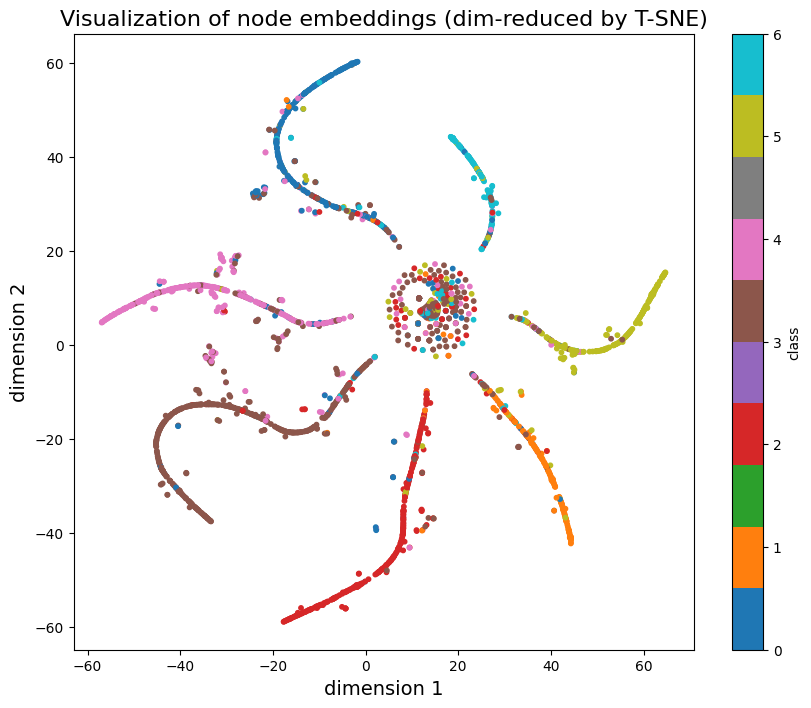

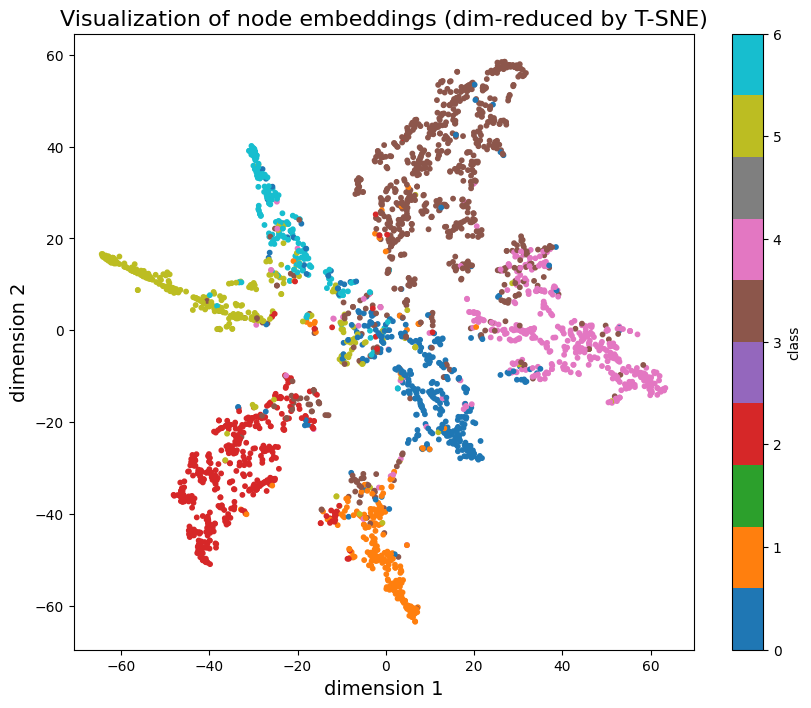

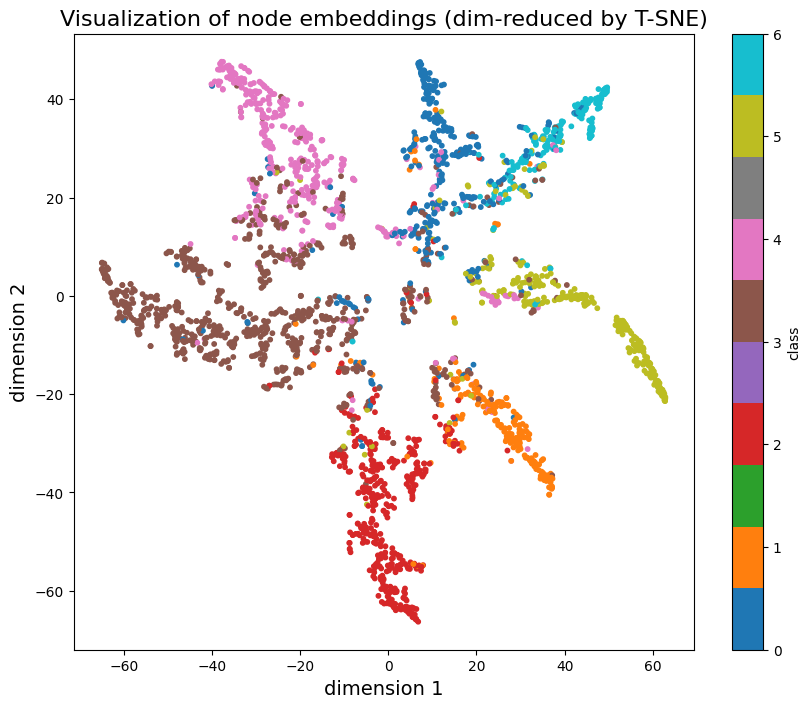

In [ ]:
visualise(feature_dict)